In [1]:
import os

# Standard: theano
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

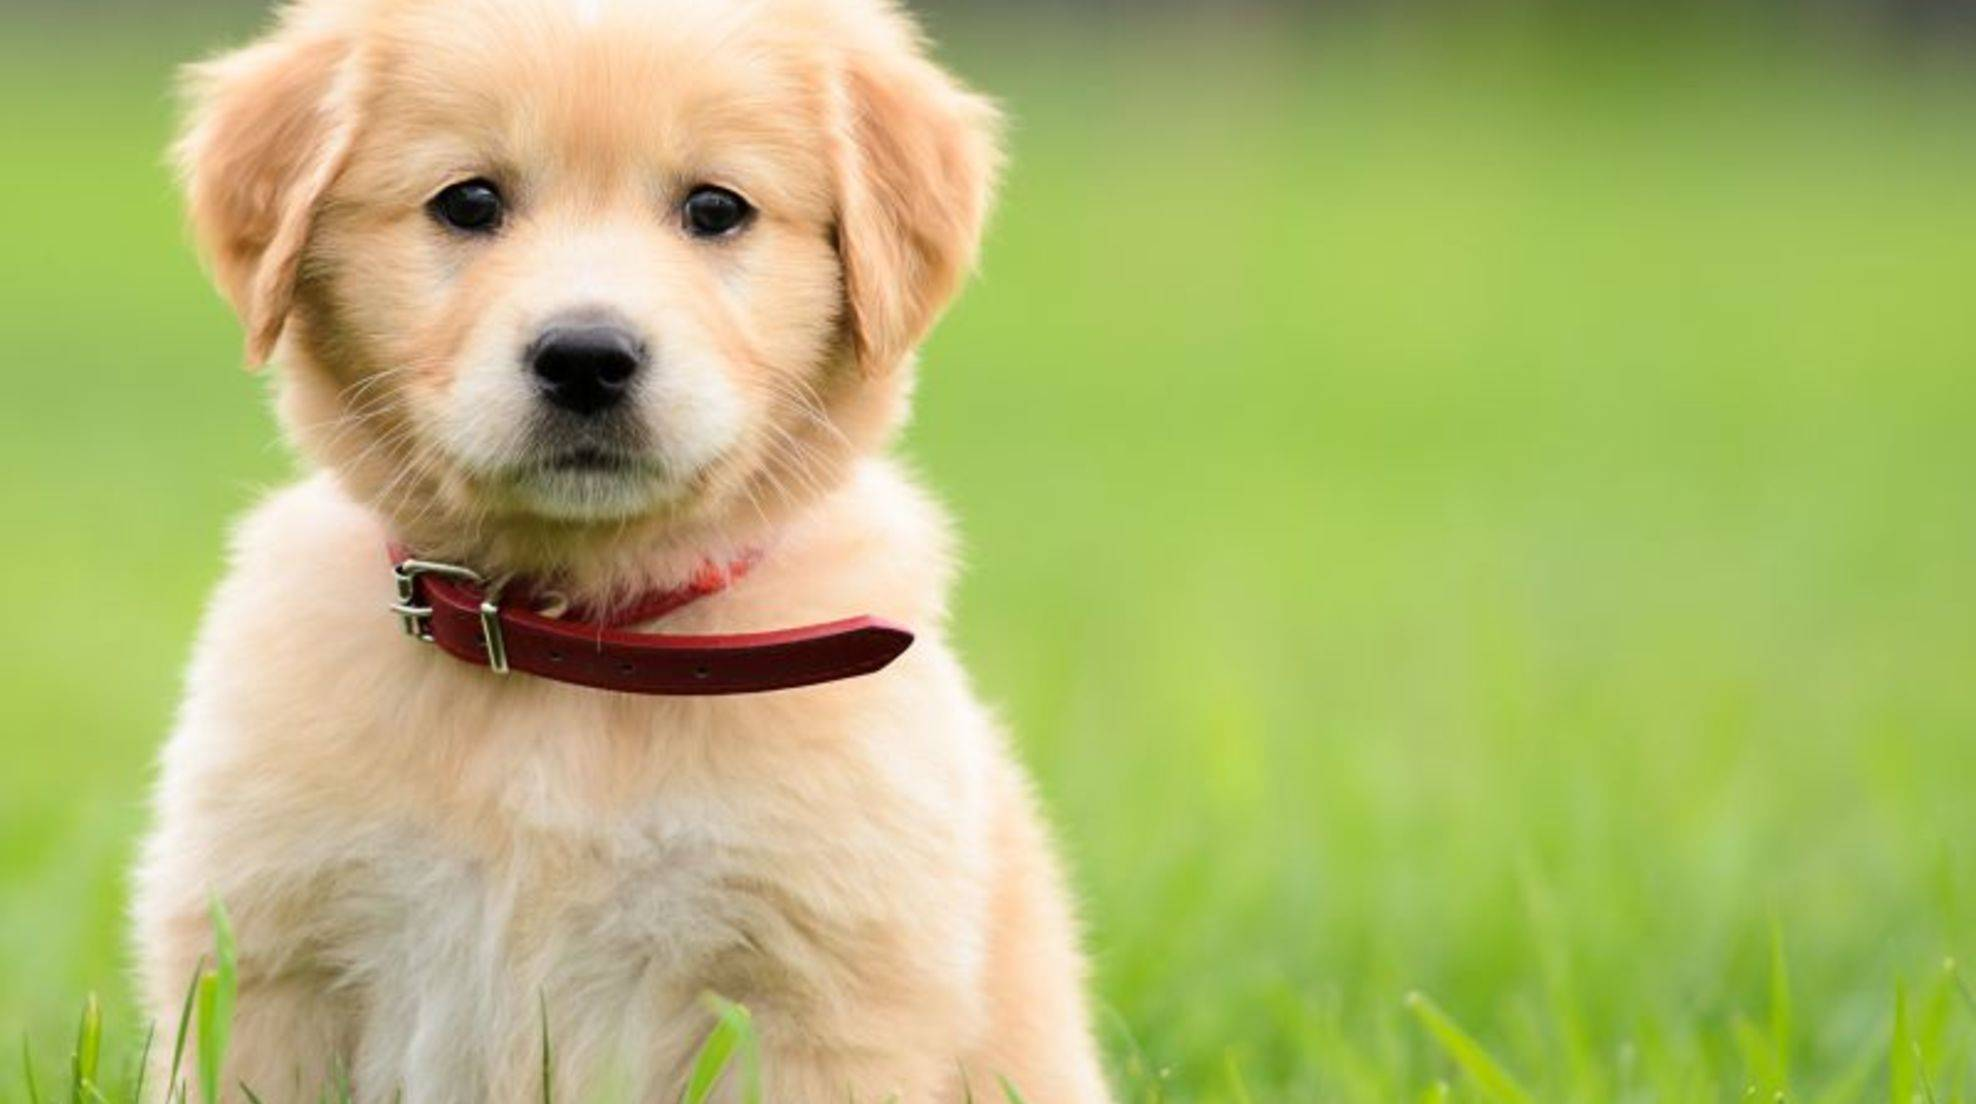

In [2]:
model_builder = keras.applications.xception.Xception
# Das Xception-Model erwartet Bilder folgender Größe 
img_size = (299, 299)
# Für die Vorverarbeitung, jedes Modell stellt Anforderungen an die Eingabedaten
preprocess_input = keras.applications.xception.preprocess_input
# Liste von Wahrscheinlichkeiten -> lesbare Labels (z.B. "Hund", "Katze")
decode_predictions = keras.applications.xception.decode_predictions

# Einer vor GAP Layer 
last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "hund.jpg", "https://einfachtierisch.de/media/cache/article_main_image_tablet/cms/2013/05/Hundewelpe-Retriever-Halsband.jpg?522506"
)

display(Image(img_path))

In [3]:
# Skalieren + in NumPy-Array
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    # Jeder Pixelwert im Bild wird dabei in einen numerischen Wert im Array übersetzt
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3) ???????????????
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # 1 Input (Bild), 2 Outputs (Aktivierungen der letzten Schicht und Vorhersage)
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # Jeder Eintrag mittlere Intensität der Gradienten (für ein Feature ?)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    # Matrixmultiplikation (@) zwischen der Ausgabe der, dann eine Addition 
    # letzten konvolutionellen Schicht und den gepoolten Gradienten durchgeführt
    # (Das was in den Folien erklärt wurde ? Gewciht * Feature ?)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # 1. Quotient: Alle negativen Werte werden entfernt 
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

[[[[ 0.01176476  0.082353   -0.1607843 ]
   [ 0.01176476  0.082353   -0.1607843 ]
   [ 0.00392163  0.07450986 -0.16862744]
   ...
   [-0.38039213 -0.38039213 -0.44313723]
   [-0.372549   -0.372549   -0.4352941 ]
   [-0.372549   -0.372549   -0.4352941 ]]

  [[ 0.02745104  0.10588241 -0.1607843 ]
   [ 0.02745104  0.10588241 -0.1607843 ]
   [ 0.01176476  0.09019613 -0.17647058]
   ...
   [-0.372549   -0.36470586 -0.42745095]
   [-0.38039213 -0.372549   -0.4352941 ]
   [-0.38039213 -0.372549   -0.4352941 ]]

  [[ 0.02745104  0.10588241 -0.18431371]
   [ 0.02745104  0.10588241 -0.18431371]
   [ 0.02745104  0.10588241 -0.18431371]
   ...
   [-0.41176468 -0.36470586 -0.44313723]
   [-0.40392154 -0.35686272 -0.4352941 ]
   [-0.38823527 -0.34117645 -0.41960782]]

  ...

  [[ 0.09803927  0.4039216  -0.4980392 ]
   [ 0.14509809  0.4431373  -0.44313723]
   [ 0.19215691  0.49803925 -0.40392154]
   ...
   [ 0.12941182  0.427451   -0.52156866]
   [ 0.07450986  0.35686278 -0.3490196 ]
   [ 0.07450986 

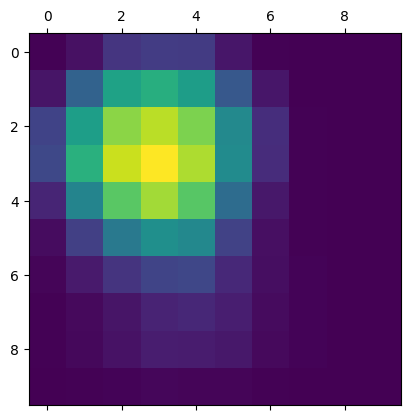

In [4]:
# Prepare image
# Parameter: Numpy Array
# Das Ergebnis ist ein vorverarbeitetes Bild, das für die Verwendung mit dem Xception-Modell geeignet ist (Als Numpy-Array)
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print(img_array)

# Make model
# Model wird erstellt, Gewichte sind auf ImageNet vortrainiert 
model = model_builder(weights="imagenet")

# Remove last layer's softmax
# Softmax layer wird entfernt 
model.layers[-1].activation = None # OPTIONAL

# Print what the top predicted class is
# preds enthält die Vorhersagewahrscheinlichkeit für jede Klasse 
# decode: Wahrscheinlichkeit -> Klassenbezeichnung 
preds = model.predict(img_array)
# n02099601 ist die ID im ImageNet Datensatz 
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
# Grobe Darstellung der Bereiche im Bild
plt.show()

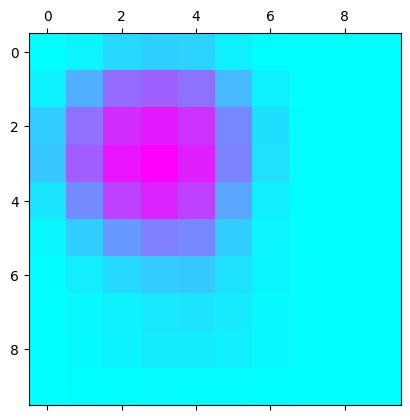

In [5]:
plt.matshow(heatmap, cmap='cool')
plt.show()

In [6]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


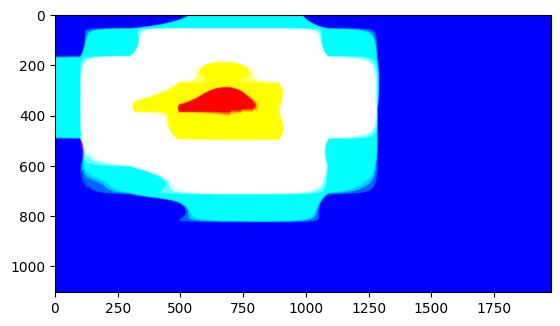

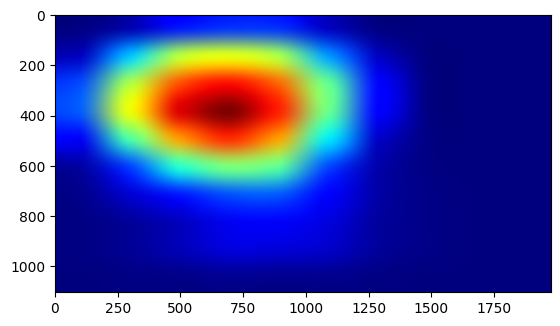

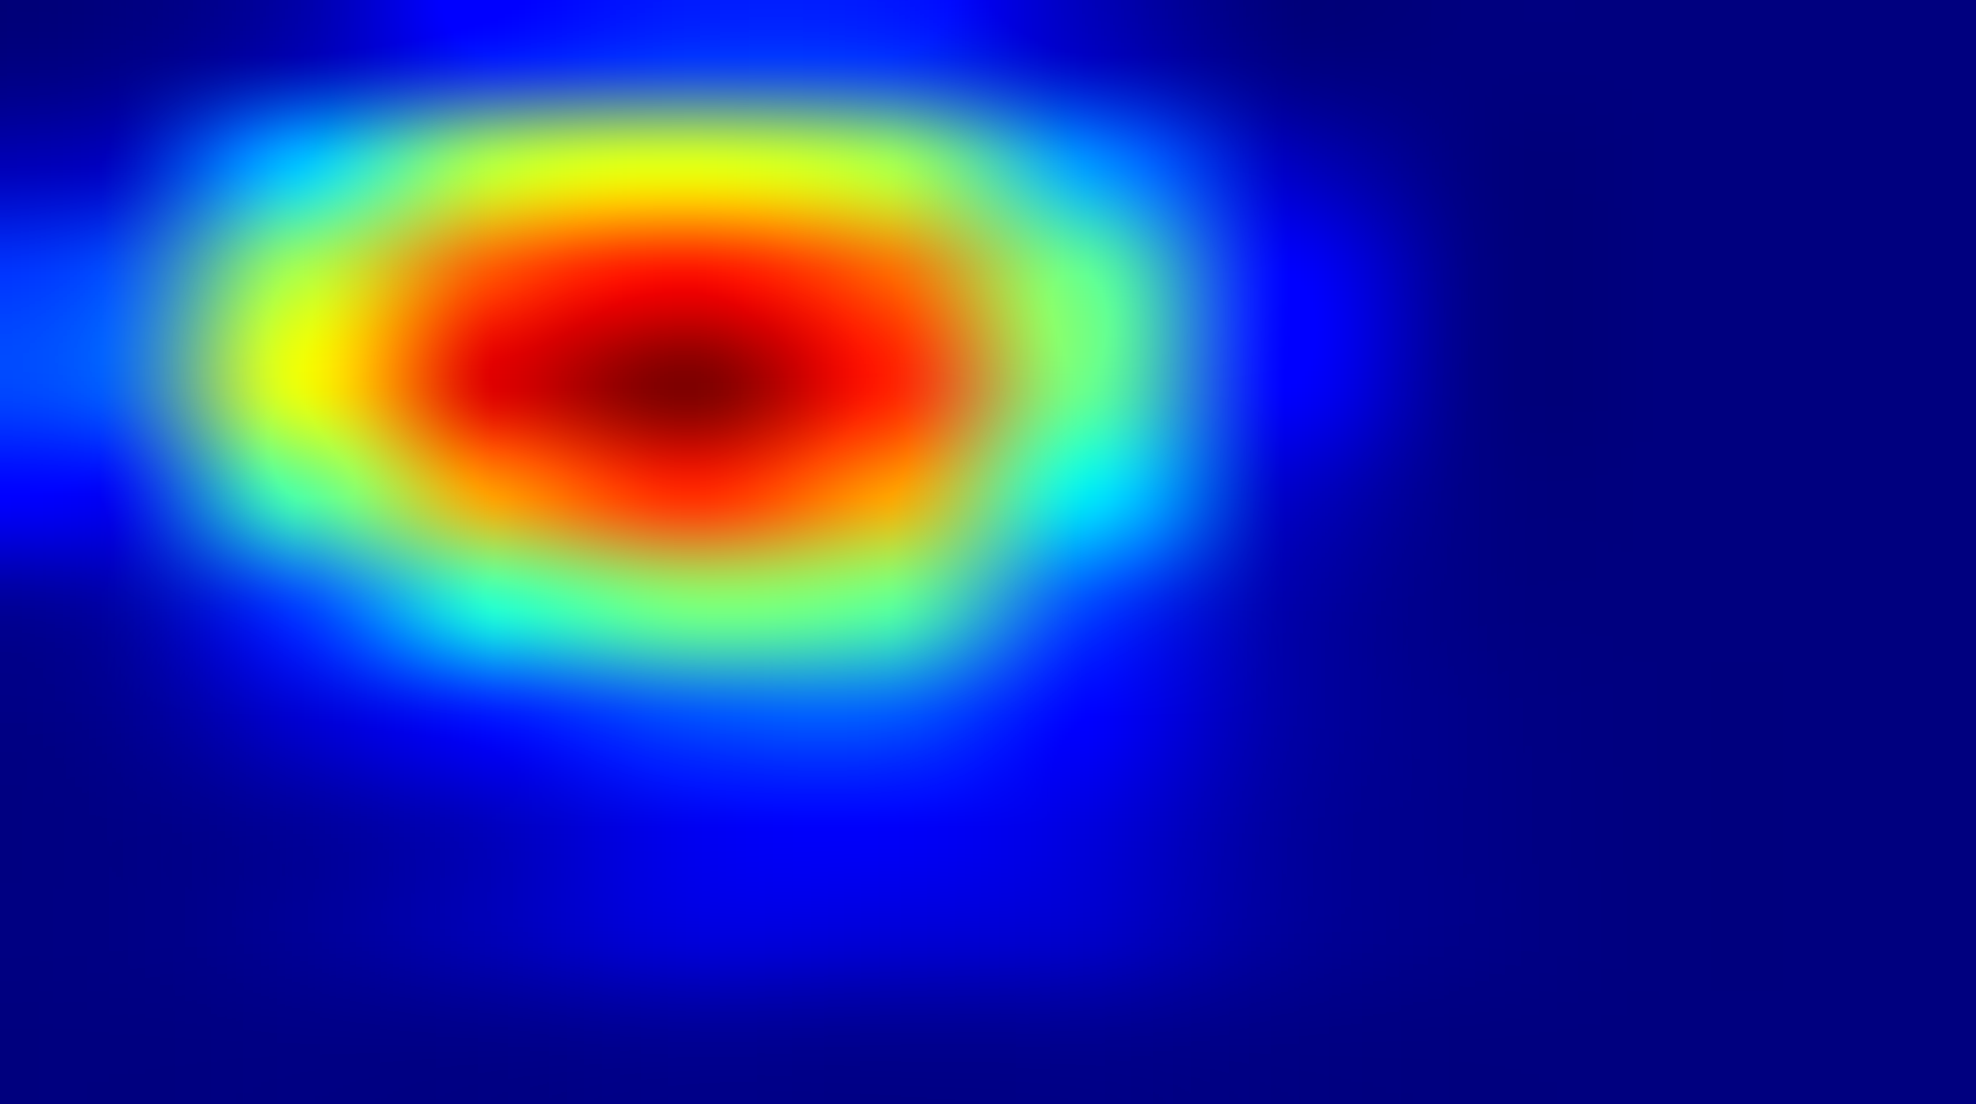

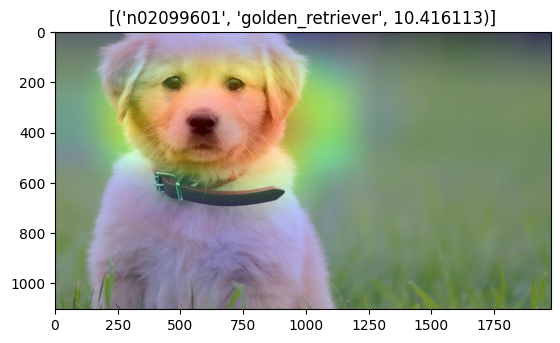

In [23]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # ADDED
    #plt.imshow(jet_heatmap)
    #plt.show()

    # Superimpose the heatmap on original image
    #superimposed_img = jet_heatmap * alpha + img
    superimposed_img = jet_heatmap * alpha 
    # ADDED
    plt.imshow(superimposed_img)
    plt.show()
    #superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # ADDED
    plt.imshow(superimposed_img)
    plt.show()
    display(superimposed_img)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path)) --> Original
    plt.imshow(superimposed_img)
    #plt.colorbar()
    plt.title(decode_predictions(preds, top=1)[0])


save_and_display_gradcam(img_path, heatmap)